c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                                text     label
0  ডিরেক্টলি গেলে প্লেনে যেতে হবে । সেই ক্ষেত্রে ...   neutral
1         অন্তিম অবতারের পিতার নাম হবে ' বিষ্ণু যশা    neutral
2                    দাদা বোগরাতে এমন খাবার কথাই পাব   neutral
3  কোরবানি ঈদের সাথে মিল রেখে এক্সট্রা অর্ডিনারী ...   neutral
4                           আপনার মতো একজন বুদ্ধিমান  positive


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 4946/4946 [00:00<00:00, 8025.39 examples/s] 
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_8988\3531718337.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.806400,0.830348,0.635261,0.629747
2,0.793400,0.765071,0.660332,0.656952
3,0.694900,0.768708,0.682370,0.679937



 Evaluation results: {'eval_loss': 0.7687084674835205, 'eval_accuracy': 0.682369591589163, 'eval_f1': 0.6799366324466009, 'eval_runtime': 40.1337, 'eval_samples_per_second': 123.238, 'eval_steps_per_second': 30.822, 'epoch': 3.0}
 Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.71      0.69      1648
     neutral       0.63      0.54      0.58      1387
    positive       0.72      0.75      0.74      1911

    accuracy                           0.68      4946
   macro avg       0.67      0.67      0.67      4946
weighted avg       0.68      0.68      0.68      4946



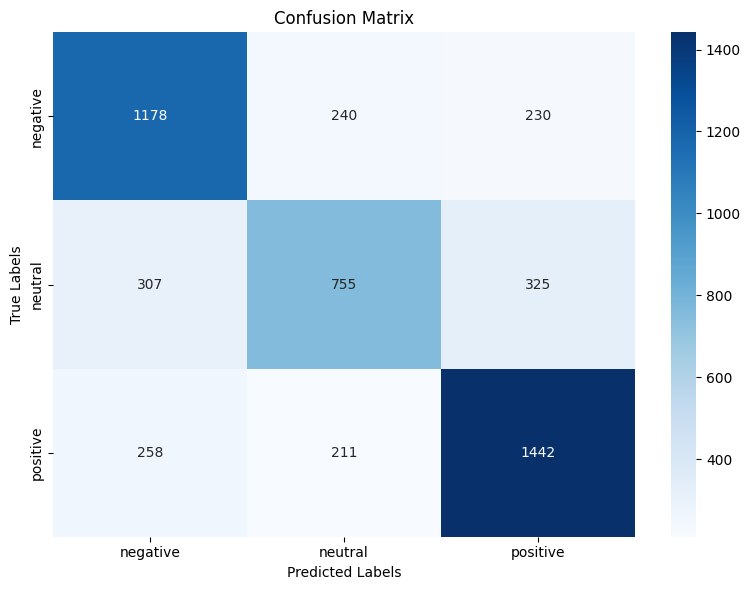

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os

# Load dataset
df = pd.read_csv('3c_sentiment.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load BanglaBERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
